# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [112]:
pd.set_option('max_colwidth', 100)

# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [11]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_

In [12]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [13]:
formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [14]:
print(formula)

total_points ~ C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [15]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [16]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

### Linear kernel

In [17]:
linear_estimator = SVR(kernel='linear', epsilon=1.96, C=0.0123)
linear_selector = RFECV(linear_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)

linear_selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=SVR(C=0.0123, cache_size=200, coef0=0.0, degree=3, epsilon=1.96,
                    gamma='auto_deprecated', kernel='linear', max_iter=-1,
                    shrinking=True, tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [18]:
sum(linear_selector.support_)

80

In [19]:
linear_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [20]:
ridge_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [21]:
# X_sel = X[:,linear_selector.support_]
# X_train_sel = X_train[:,linear_selector.support_]
# X_test_sel = X_test[:,linear_selector.support_]

X_sel = X[:,ridge_features_index]
X_train_sel = X_train[:,ridge_features_index]
X_test_sel = X_test[:,ridge_features_index]

## Tuning model

### GP tuner

#### Linear kernel regression

In [30]:
linear_space  = [
    Real(1, 3, 'uniform', name='epsilon'),
    Real(10**-2, 10**1, 'log-uniform', name='C'),
]

In [31]:
linear_gp_model = SVR(kernel='linear')

@use_named_args(linear_space)
def linear_objective(**params):
    linear_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            linear_gp_model,
#             X,
            X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [32]:
linear_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    linear_res_gp = gp_minimize(linear_objective, linear_space, n_calls=50, verbose=2)
    linear_res_gp_arr.append(linear_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3893
Function value obtained: 9.3513
Current minimum: 9.3513
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0992
Function value obtained: 9.4998
Current minimum: 9.3513
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3695
Function value obtained: 9.7350
Current minimum: 9.3513
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3931
Function value obtained: 9.2802
Current minimum: 9.2802
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1998
Function value obtained: 9.5990
Current minimum: 9.2802
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.4671
Function value obtained: 9.2668
Current minimum: 9.2649
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.3982
Function value obtained: 9.2673
Current minimum: 9.2649
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.4925
Function value obtained: 9.2674
Current minimum: 9.2649
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.3504
Function value obtained: 9.2651
Current minimum: 9.2649
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.4891
Function value obtained: 9.2671
Current minimum: 9.2649
Iteration No: 46 started. Sea

In [33]:
# Ridge features
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.26488716295751


[1.9243289485475958, 3.049208154301481]


In [27]:
# RFE features
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.510554470618557


[1.9529406325926788, 0.008245170349672077]


In [20]:
# Full features
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.506218758911025


[1.9576678718709655, 0.012337795442371478]


#### RBF kernel regression

In [46]:
rbf_space  = [
    Real(1, 3, 'uniform', name='epsilon'),
    Real(10**-2, 10**2, 'log-uniform', name='C'),
    Real(10**-5, 10**-1, 'log-uniform', name='gamma'),
]

In [47]:
rbf_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_space)
def rbf_objective(**params):
    rbf_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_gp_model,
#             X,
            X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [48]:
rbf_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    rbf_res_gp = gp_minimize(rbf_objective, rbf_space, n_calls=50, verbose=2)
    rbf_res_gp_arr.append(rbf_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3272
Function value obtained: 9.8076
Current minimum: 9.8076
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4284
Function value obtained: 9.4863
Current minimum: 9.4863
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4770
Function value obtained: 9.3369
Current minimum: 9.3369
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4483
Function value obtained: 11.0209
Current minimum: 9.3369
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4159
Function value obtained: 10.4401
Current minimum: 9.3369
Iteratio

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.5324
Function value obtained: 9.2777
Current minimum: 9.2700
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.6151
Function value obtained: 9.2974
Current minimum: 9.2700
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.4887
Function value obtained: 9.2978
Current minimum: 9.2700
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.4514
Function value obtained: 9.3305
Current minimum: 9.2700
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.5604
Function value obtained: 9.7957
Current minimum: 9.2700
Iteration No: 46 started. Sea

In [49]:
# Ridge features
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.27002242592813


[1.953284419127078, 100.0, 0.0010276211823297006]


In [39]:
# RFE features
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.49589123100063


[1.9727942889469607, 2.1168020039526745, 0.0034209361272424968]


In [42]:
# Full features (without elements)
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.499430371447856


[2.097559086102418, 1.1178155216840122, 0.016825846721740607]


### Grid search

#### Linear kernel regression

In [26]:
linear_epsilon = [2.0]
linear_C = [0.5, 5, 50, 500, 5000]

linear_parameters = {
    'C': linear_C,
    'epsilon': linear_epsilon
}

In [27]:
gs_model_linear = GridSearchCV(
    SVR(kernel='linear'),
    linear_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_linear.fit(X_sel, y.ravel())

Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [0.5, 5, 50, 500, 5000], 'epsilon': [2.0]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [28]:
gs_model_linear_df = pd.DataFrame(gs_model_linear.cv_results_)[[
    'param_C','param_epsilon',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_linear_df

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.5,2,-2.161457,-9.280048
1,5,2,-2.162295,-9.271469
2,50,2,-2.162783,-9.272073
3,500,2,-2.162962,-9.271801
4,5000,2,-2.164446,-9.271147


In [29]:
gs_model_linear_df[
    gs_model_linear_df['split0_test_neg_mean_squared_error'] == \
    gs_model_linear_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
4,5000,2,-2.164446,-9.271147


#### RBF kernel regression

In [34]:
rbf_epsilon = [2]
rbf_C = [0.5, 5, 50, 500, 5000]
rbf_gamma = [0.01]

rbf_parameters = {
    'C': rbf_C,
    'epsilon': rbf_epsilon,
    'gamma': rbf_gamma
}

In [35]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_rbf.fit(X_sel, y.ravel())

Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [0.5, 5, 50, 500, 5000], 'epsilon': [2],
                         'gamma': [0.01]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [36]:
gs_model_rbf_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon', 'param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.5,2,0.01,-2.200466,-9.443153
1,5,2,0.01,-2.196776,-9.322164
2,50,2,0.01,-2.195197,-9.296395
3,500,2,0.01,-2.199613,-9.395980
4,5000,2,0.01,-2.209978,-9.434526


In [37]:
gs_model_rbf_df[
    gs_model_rbf_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
2,50,2,0.01,-2.195197,-9.296395


# Evaluating model

## Linear kernel

In [65]:
linear_model = SVR(kernel='linear', epsilon=1.92, C=3.05)
linear_model.fit(X_train_sel, y_train.ravel())

SVR(C=3.05, cache_size=200, coef0=0.0, degree=3, epsilon=1.92,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [66]:
# get predictions for test set
linear_y_pred = linear_model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
linear_test_loss = (
    mean_absolute_error(y_test, linear_y_pred),
    mean_squared_error(y_test, linear_y_pred),
    r2_score(y_test, linear_y_pred)
)
linear_test_loss

(2.1408568349883583, 9.267972755566724, 0.10943289803588996)

In [67]:
# refit linear_model on all data
linear_model_full = SVR(kernel='linear', epsilon=1.92, C=3.05)
linear_model_full.fit(X_sel, y.ravel())

SVR(C=3.05, cache_size=200, coef0=0.0, degree=3, epsilon=1.92,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [68]:
# get predictions for whole set
linear_y_pred_full = linear_model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
linear_test_loss_full = (
    mean_absolute_error(y, linear_y_pred_full),
    mean_squared_error(y, linear_y_pred_full),
    r2_score(y, linear_y_pred_full)
)
linear_test_loss_full

(2.131834557203807, 8.609396772488065, 0.10024085579833242)

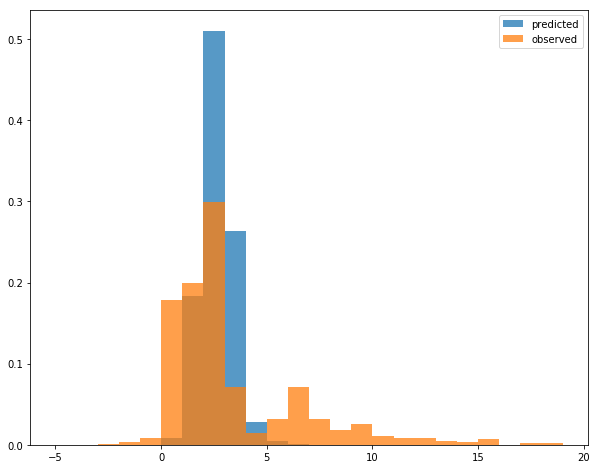

In [69]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

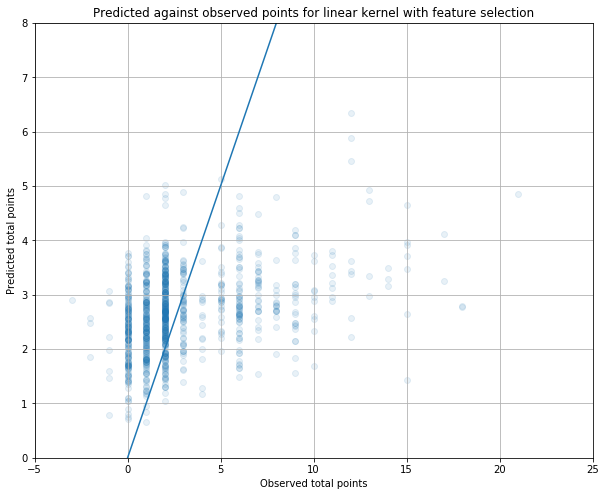

In [81]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(linear_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.title('Predicted against observed points for linear kernel with feature selection')
plt.xlim(-5, 25)
plt.ylim(0, 8)
plt.grid()
plt.show()

### Model analysis

[0.7505721638538407,
 0.5054621933418844,
 -0.5200925825249731,
 0.33430479074399067,
 0.12107004613894645,
 0.0839187277868696,
 0.19162995283409856,
 0.34396359376304986,
 -0.2573791806429355,
 0.12568351420378576]

In [113]:
pd.DataFrame(list(zip(
    list(np.array(X.design_info.column_names)[ridge_features_index]),
    list(linear_model.coef_[0])
)), columns=['feature', 'weight']).sort_values('weight', ascending=False)

,feature,weight
0,C(team)[T.12],0.750572
1,C(opposition_team)[T.9],0.505462
7,rolling_avg_minutes_element_p3,0.343964
3,value,0.334305
6,rolling_avg_saves_element,0.191630
9,expected_total_points_against_opposition_team_home_away,0.125684
4,rolling_avg_key_passes_element,0.121070
5,rolling_avg_big_chances_missed_element,0.083919
8,rolling_avg_goals_scored_opposition_team,-0.257379
2,C(opposition_team)[T.12],-0.520093


## RBF kernel

In [71]:
rbf_model = SVR(kernel='rbf', epsilon=1.95, C=100, gamma=0.00103)
rbf_model.fit(X_train_sel, y_train.ravel())

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=1.95, gamma=0.00103,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [72]:
# get predictions for test set
rbf_y_pred = rbf_model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
rbf_test_loss = (
    mean_absolute_error(y_test, rbf_y_pred),
    mean_squared_error(y_test, rbf_y_pred),
    r2_score(y_test, rbf_y_pred)
)
rbf_test_loss

(2.1639119305234766, 9.269219126410645, 0.10931313323945413)

In [73]:
# refit rbf_model on all data
rbf_model_full = SVR(kernel='rbf', epsilon=1.95, C=100, gamma=0.00103)
rbf_model_full.fit(X_sel, y.ravel())

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=1.95, gamma=0.00103,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [74]:
# get predictions for whole set
rbf_y_pred_full = rbf_model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
rbf_test_loss_full = (
    mean_absolute_error(y, rbf_y_pred_full),
    mean_squared_error(y, rbf_y_pred_full),
    r2_score(y, rbf_y_pred_full)
)
rbf_test_loss_full

(2.139098287840825, 8.590755452294998, 0.10218904087412106)

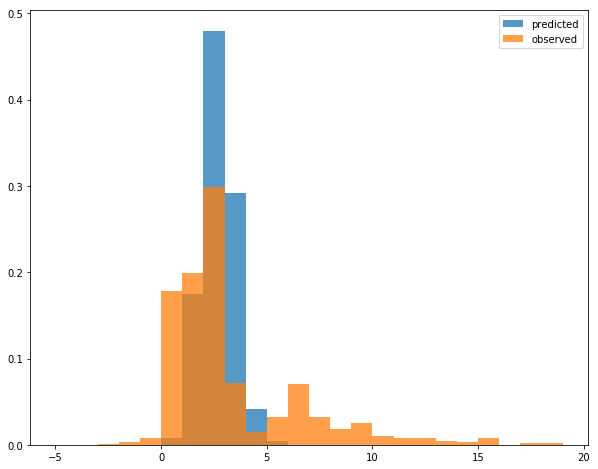

In [75]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

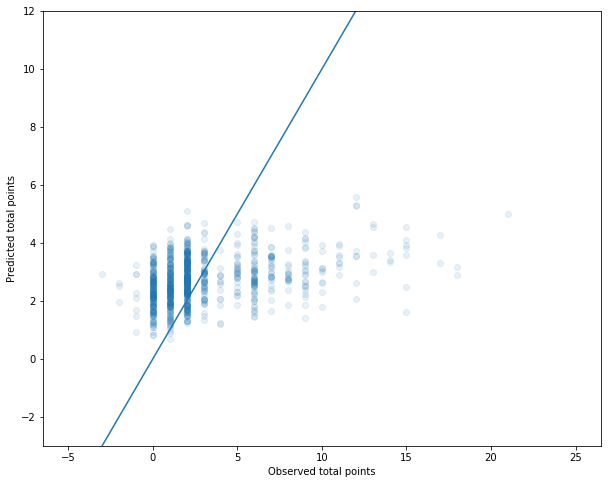

In [76]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(rbf_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [77]:
pd.DataFrame([
    ('Linear kernel', linear_test_loss[0], linear_test_loss[1], linear_test_loss[2]),
    ('RBF kernel', rbf_test_loss[0], rbf_test_loss[1], rbf_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear kernel,2.140857,9.267973,0.109433
1,RBF kernel,2.163912,9.269219,0.109313


In [78]:
pd.DataFrame([
    ('Linear kernel', linear_test_loss_full[0], linear_test_loss_full[1], linear_test_loss_full[2]),
    ('RBF kernel', rbf_test_loss_full[0], rbf_test_loss_full[1], rbf_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear kernel,2.131835,8.609397,0.100241
1,RBF kernel,2.139098,8.590755,0.102189
